In [40]:
import rasterio
import numpy as np
from scipy.ndimage import generic_filter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import csv
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.transform import xy

/opt/anaconda3/envs/cliff_pipeline/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Wrote 1489 points to /Users/cjmack/Documents/Papers/Cliffs/Scratch/shoreline_xyz.csv


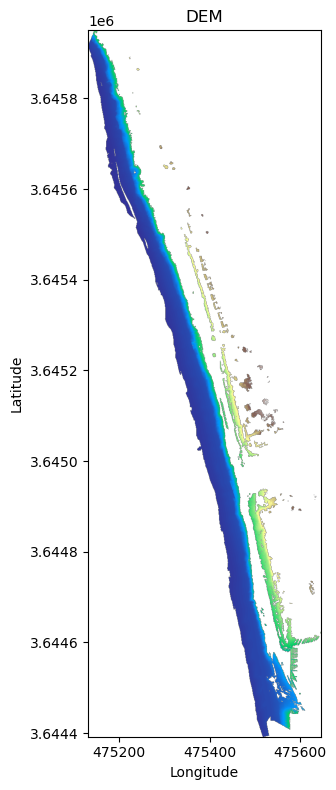

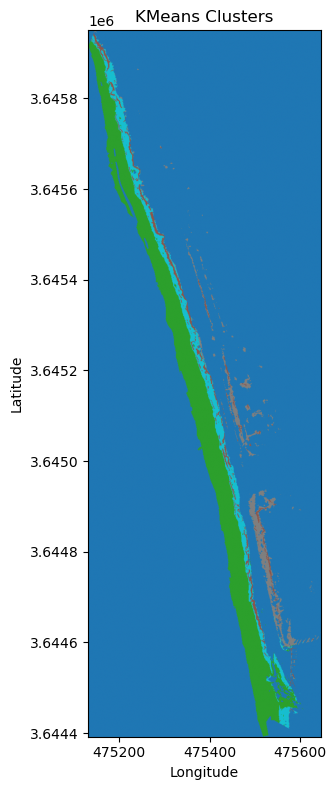

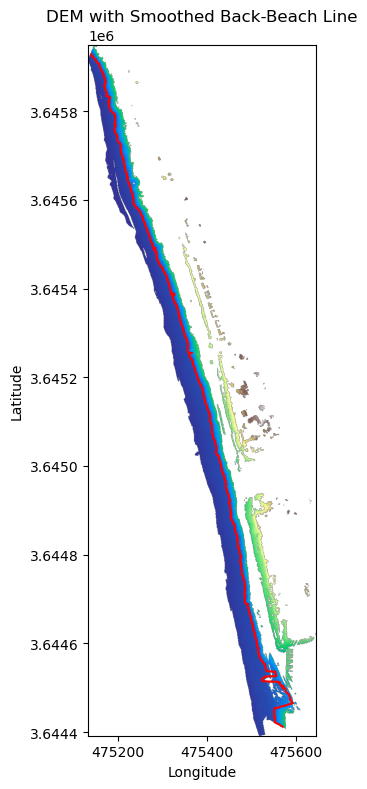

In [ ]:
# Path to your GeoTIFF
tif_path = "\\reefbreak.ucsd.edu\group\LiDAR\VMQLZ_Truck\LiDAR_Processed_Level2\20250505_00683_00722_1244_Cardiff_Moonlight_NoWaves\Beach_And_Backshore\20250505_00683_00722_1244_Cardiff_Moonlight_NoWaves_beach_cliff_ground.tif"

# 1) Read DEM + metadata
with rasterio.open(tif_path) as src:
    dem       = src.read(1, masked=True)
    transform = src.transform
    crs       = src.crs
    res_x, res_y = src.res
    height, width = dem.shape

# 2) Prepare features: elevation, slope, roughness
elev = dem.filled(np.nan)
dy, dx = np.gradient(elev, res_y, res_x)
slope = np.sqrt(dx**2 + dy**2)

def local_std(window):
    return np.nanstd(window)

roughness = generic_filter(
    elev,
    function=local_std,
    size=5,
    mode="constant",
    cval=np.nan
)

# 3) Stack & mask
stack = np.dstack([elev, slope, roughness])
valid = (
    (~dem.mask)
    & ~np.isnan(elev)
    & ~np.isnan(slope)
    & ~np.isnan(roughness)
)

# 4) Cluster
X        = stack[valid]
X_scaled = StandardScaler().fit_transform(X)
k        = 4
km       = KMeans(n_clusters=k, random_state=0).fit(X_scaled)

labels = np.full(dem.shape, -1, dtype=int)
labels[valid] = km.labels_

# 5) Identify beach cluster
beach_idx = np.argmin(km.cluster_centers_.sum(axis=1))

# 6) Extract back-beach boundary points (min_run logic)
shoreline_pts = []
min_run = 3

for i in range(height):
    in_beach = False
    j = 0
    while j < width:
        lbl = labels[i, j]
        if not in_beach:
            if lbl == beach_idx:
                in_beach = True
            j += 1
        else:
            if not valid[i, j]:
                j += 1
                continue
            if lbl != beach_idx:
                count = 1
                k2 = j + 1
                while k2 < width and count < min_run:
                    if not valid[i, k2]:
                        k2 += 1
                        continue
                    if labels[i, k2] != beach_idx:
                        count += 1
                        k2 += 1
                    else:
                        break
                if count >= min_run:
                    x, y = xy(transform, i, j, offset="center")
                    z     = float(dem[i, j])
                    shoreline_pts.append((x, y, z))
                    break
            j += 1

# 7) Smooth outlier z-values
xs, ys, zs = zip(*shoreline_pts)
zs = np.array(zs)
median_z = np.median(zs)
mad_z    = np.median(np.abs(zs - median_z))
threshold = 3 * mad_z
inliers   = np.abs(zs - median_z) <= threshold
zs_smoothed = zs.copy()

for idx, ok in enumerate(inliers):
    if not ok:
        prev = np.where(inliers[:idx])[0]
        nxt  = np.where(inliers[idx+1:])[0] + idx + 1
        if prev.size and nxt.size:
            zs_smoothed[idx] = 0.5 * (zs[prev[-1]] + zs[nxt[0]])
        elif prev.size:
            zs_smoothed[idx] = zs[prev[-1]]
        elif nxt.size:
            zs_smoothed[idx] = zs[nxt[0]]
        else:
            zs_smoothed[idx] = median_z

shoreline_smoothed = list(zip(xs, ys, zs_smoothed))

# 8) Write CSV
csv_path = "/Users/cjmack/Documents/Papers/Cliffs/Scratch/shoreline_xyz.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["x", "y", "z"])
    writer.writerows(shoreline_smoothed)
print(f"Wrote {len(shoreline_smoothed)} points to {csv_path}")

# 9) Plot Figure 1: DEM alone
fig1, ax1 = plt.subplots(figsize=(8, 8))
show(dem, transform=transform, ax=ax1, cmap="terrain")
ax1.set_title("DEM")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
plt.tight_layout()

# 10) Plot Figure 2: KMeans clusters alone
fig2, ax2 = plt.subplots(figsize=(8, 8))
show(labels, transform=transform, ax=ax2, cmap="tab10")
ax2.set_title("KMeans Clusters")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
plt.tight_layout()

# 11) Plot Figure 3: DEM with smoothed shoreline
fig3, ax3 = plt.subplots(figsize=(8, 8))
show(dem, transform=transform, ax=ax3, cmap="terrain")
xs2, ys2, _ = zip(*shoreline_smoothed)
ax3.plot(xs2, ys2, color="red", linewidth=1.5)
ax3.set_title("DEM with Smoothed Back-Beach Line")
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")
plt.tight_layout()

plt.show()